KNN

In [ ]:
!pip install yfinance
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [ ]:
df = yf.download('SPY', start='2015-01-01', end='2020-01-01')
df = df[['Open', 'High', 'Low', 'Close']]
print(df.head())

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close
Date                                                      
2015-01-02  206.380005  206.880005  204.179993  205.429993
2015-01-05  204.169998  204.369995  201.350006  201.720001
2015-01-06  202.089996  202.720001  198.860001  199.820007
2015-01-07  201.419998  202.720001  200.880005  202.309998
2015-01-08  204.009995  206.160004  203.990005  205.899994


In [ ]:
df = df.dropna()
df['Open - Close'] = df.Open - df.Close
df['High - Low'] = df.High - df.Low
x = df[['Open - Close', 'High - Low']]
print(df.head())

                  Open        High  ...  Open - Close  High - Low
Date                                ...                          
2015-01-02  206.380005  206.880005  ...      0.950012    2.700012
2015-01-05  204.169998  204.369995  ...      2.449997    3.019989
2015-01-06  202.089996  202.720001  ...      2.269989    3.860001
2015-01-07  201.419998  202.720001  ...     -0.889999    1.839996
2015-01-08  204.009995  206.160004  ...     -1.889999    2.169998

[5 rows x 6 columns]


In [ ]:
y = np.where(df['Close'].shift(-1) > df['Close'], +1, -1) #전날 종가보다 오르면 1점 아니면 -1점

In [ ]:
train_pct = 0.7
split = int(train_pct * len(df))
x_train, x_test, y_train, y_test = x[:split],x[split:],y[:split],y[split:]

In [ ]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(x_train, y_train)
accuracy_train = accuracy_score(y_train, knn.predict(x_train))
accuracy_test = accuracy_score(y_test, knn.predict(x_test))
print(accuracy_train, accuracy_test)

0.6261363636363636 0.544973544973545


In [ ]:
df['Signal'] = knn.predict(x)
df['SPY_returns'] = np.log(df['Close']/df['Close'].shift(1))
cum_SPY_returns = df['SPY_returns'].cumsum()*100

In [ ]:
df['STR_returns'] = df['SPY_returns']*df['Signal'].shift(1)
cum_Signal_returns = df['STR_returns'].cumsum()*100

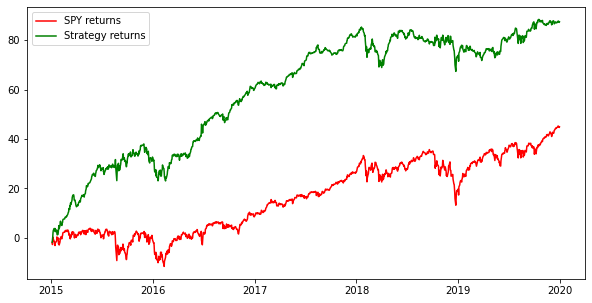

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(cum_SPY_returns, color='r', label='SPY returns')
plt.plot(cum_Signal_returns, color='g', label='Strategy returns')
plt.legend()
plt.show()

In [ ]:
std_signal = cum_Signal_returns.std()
sharpe = (cum_Signal_returns - cum_SPY_returns) / std_signal
sharpe = sharpe.mean()
print(sharpe)

1.7864279256384141


Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [ ]:
df = yf.download('SPY', start='2015-01-01', end='2020-01-01')
df = df[['Open', 'High', 'Low', 'Close']]
print(df.head())

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close
Date                                                      
2015-01-02  206.380005  206.880005  204.179993  205.429993
2015-01-05  204.169998  204.369995  201.350006  201.720001
2015-01-06  202.089996  202.720001  198.860001  199.820007
2015-01-07  201.419998  202.720001  200.880005  202.309998
2015-01-08  204.009995  206.160004  203.990005  205.899994


In [ ]:
df['MA10'] = df['Close'].rolling(window=10).mean() #10일 이동평균
df['Corr'] = df['Close'].rolling(window=10).corr(df['MA10']) #이동상관계수
df['OpenClose'] = df.Open - df.Close.shift(1) #시가와 전날 종가 차이
df['OpenOpen'] = df.Open - df.Open.shift(1) #시가와 전날 시가 차이
df = df.dropna()
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Open,High,Low,Close,MA10,Corr,OpenClose,OpenOpen
Date,,,,,,,,
2015-01-29,200.380005,202.300003,198.679993,201.990005,202.718002,0.461444,0.240005,-3.789993
2015-01-30,200.570007,202.169998,199.130005,199.449997,202.761002,0.259196,-1.419998,0.190002
2015-02-02,200.050003,202.029999,197.860001,201.919998,202.790001,0.151315,0.600006,-0.520004
2015-02-03,203.000000,204.850006,202.550003,204.839996,203.068001,0.256788,1.080002,2.949997
2015-02-04,203.919998,205.380005,203.509995,204.059998,203.166000,0.353739,-0.919998,0.919998


In [ ]:
x = df[['Open','High','Low','Close','MA10','Corr','OpenClose','OpenOpen']]
y = np.where(df['Close'] > df['Close'].shift(-1), 1, -1)

In [ ]:
train_pct = 0.8
split = int(train_pct * len(df))
x_train, x_test, y_train, y_test = x[:split],x[split:],y[:split],y[split:]

In [ ]:
model = LogisticRegression()
model = model.fit(x_train, y_train)
pd.DataFrame(zip(x.columns, np.transpose(model.coef_)))

,0,1
0,Open,[-0.23810928640649456]
1,High,[0.20650514646425433]
2,Low,[0.18436680164653887]
3,Close,[-0.12337979590684771]
4,MA10,[-0.030017481374484525]
5,Corr,[0.030652729178582305]
6,OpenClose,[0.03283784571779483]
7,OpenOpen,[-0.011576903003137672]


In [ ]:
probability = model.predict_proba(x_test)
predicted = model.predict(x_test)
print(predicted)

[-1  1  1 -1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1  1 -1 -1 -1 -1
  1  1  1  1  1 -1 -1 -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1  1 -1  1 -1
 -1 -1  1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1  1  1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1  1 -1  1  1  1 -1  1 -1 -1  1  1 -1 -1  1 -1 -1 -1 -1 -1
 -1 -1  1 -1 -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1
 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1
 -1 -1 -1  1 -1  1 -1 -1  1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1  1 -1 -1  1
  1 -1  1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1  1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1]


In [ ]:
print(model.score(x_test, y_test))

0.5443548387096774


In [ ]:
df['Signal'] = model.predict(x)
df['SPY_returns'] = np.log(df['Close'] / df['Close'].shift(1))
cumulative_SPY_returns = np.cumsum(df[split:]['SPY_returns'])
df['STR_returns'] = df.SPY_returns * df.Signal.shift(1)
cumulative_STR_returns = np.cumsum(df[split:]['STR_returns'])

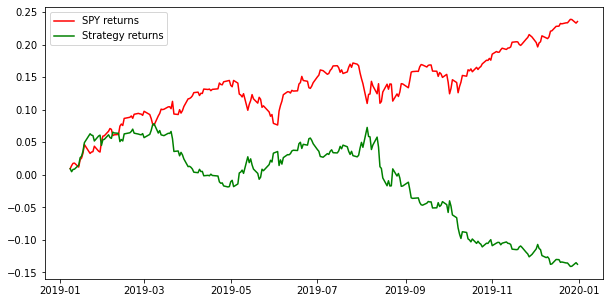

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(cumulative_SPY_returns, color='r', label='SPY returns')
plt.plot(cumulative_STR_returns, color='g', label='Strategy returns')
plt.legend()
plt.show()